## Image Classification Exercise

Binary image classification exercise with the casting parts [[url](`https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product`)] dataset on Kaggle. Inspired by Tim Busfield's notebook at https://github.com/timbusfield/TensorFlow-Notebooks.

### Setup and Configuration

In [1]:
# Import necessary Python modules
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

from pathlib import Path

print(tf.__version__)
%matplotlib inline

2.8.0


### Data preparation (Kaggle dataset)

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json`

For protection, remember to modify read-write access to the file:

```chmod 600 ~/.kaggle/kaggle.json```

In [2]:
# In case the Kaggle CLI isn't installed already

# !pip install kaggle > /dev/null

In [3]:
# Specify the location of the dataset for the CLI
# dansbecker/hot-dog-not-hot-dog
DATASET_OWNER = "ravirajsinh45"
DATASET_DIR   = "datasets"
DATASET_NAME  = "real-life-industrial-dataset-of-casting-product"
!mkdir -p "$DATASET_DIR"
!kaggle datasets download "$DATASET_OWNER"/"$DATASET_NAME" -p "$DATASET_DIR"
!unzip -o "$DATASET_DIR"/"$DATASET_NAME".zip -d "$DATASET_DIR"
!rm "$DATASET_DIR"/"$DATASET_NAME".zip

 98%|██████████████████████████████████████▏| 98.0M/100M [00:02<00:00, 46.4MB/s]
100%|████████████████████████████████████████| 100M/100M [00:02<00:00, 39.1MB/s]
Archive:  datasets/real-life-industrial-dataset-of-casting-product.zip
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_0.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_100.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_1015.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_102.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_1046.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_1053.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_1055.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_1077.jpeg  
  inflating: datasets/casting_512x512/casting_512x512/def_front/cast_def_0_1

In [4]:
path_training_data = Path(DATASET_DIR) / Path("casting_data/casting_data") / Path("train")
path_test_data     = Path(DATASET_DIR) / Path("casting_data/casting_data") / Path("test")

In [5]:
def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [7]:
SEED = 42
COLOR_MODE = "grayscale"
image_size = (300, 300)
image_shape = (300,300,1)

training_ds = get_image_data(
    path_training_data,
    COLOR_MODE,
    image_size,
    SEED,
    subset = "training" 
)
validation_ds = get_image_data(
    path_training_data,
    COLOR_MODE,
    image_size,
    SEED,
    subset = "validation"
)
test_ds = get_image_data(
    path_training_data,
    COLOR_MODE,
    image_size
)

Found 6633 files belonging to 2 classes.
Using 5307 files for training.
Found 6633 files belonging to 2 classes.
Using 1326 files for validation.
Found 6633 files belonging to 2 classes.


In [8]:
equivalence_check = training_ds["classNames"] == validation_ds["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = training_ds["classNames"]
number_classes = len(class_names)

### Data visualization

datasets/casting_data/casting_data/train/def_front/cast_def_0_7906.jpeg
datasets/casting_data/casting_data/train/def_front/cast_def_0_9610.jpeg
datasets/casting_data/casting_data/train/def_front/cast_def_0_9600.jpeg
datasets/casting_data/casting_data/train/ok_front/cast_ok_0_779.jpeg
datasets/casting_data/casting_data/train/ok_front/cast_ok_0_973.jpeg
datasets/casting_data/casting_data/train/ok_front/cast_ok_0_3149.jpeg


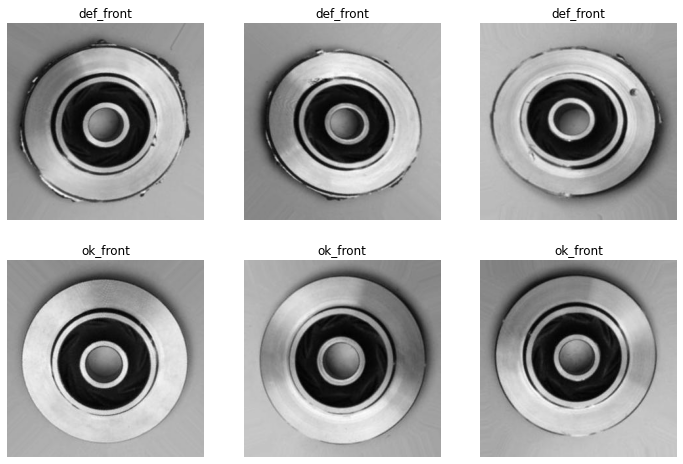

In [9]:
plt.figure(figsize=(12, 8))
counter = 1
for cls in class_names:
    path_images = path_training_data / Path(f"{cls}/*.jpeg")
    files_images = glob.glob(path_images.as_posix(),recursive = True)
    for idx in random.sample(range(0, len(files_images)), 3):
        print(files_images[idx])
        ax = plt.subplot(number_classes, 3, counter)
        plt.title(cls)
        plt.axis("off")
        plt.imshow(cv2.imread(files_images[idx]))
        counter += 1

### Model preparation (TensorFlow)

In [10]:
def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

number_colour_layers = 1

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)

dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]

model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Model creation

In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        2

### Model training

In [12]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
history = model.fit(
    training_ds["data"],
    validation_data = validation_ds["data"],
    epochs = 20,
    callbacks = [callback]
)

Epoch 1/20


2022-03-26 14:54:38.363439: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


166/166 [==============================] - 35s 210ms/step - loss: 0.5883 - accuracy: 0.7113 - val_loss: 0.4252 - val_accuracy: 0.7722
Epoch 2/20
166/166 [==============================] - 37s 223ms/step - loss: 0.3386 - accuracy: 0.8479 - val_loss: 0.2735 - val_accuracy: 0.8959
Epoch 3/20
166/166 [==============================] - 36s 214ms/step - loss: 0.2816 - accuracy: 0.8717 - val_loss: 0.2319 - val_accuracy: 0.9170
Epoch 4/20
166/166 [==============================] - 36s 217ms/step - loss: 0.2134 - accuracy: 0.9139 - val_loss: 0.1857 - val_accuracy: 0.9359
Epoch 5/20
166/166 [==============================] - 36s 216ms/step - loss: 0.1571 - accuracy: 0.9410 - val_loss: 0.1680 - val_accuracy: 0.9314
Epoch 6/20
166/166 [==============================] - 36s 214ms/step - loss: 0.1164 - accuracy: 0.9584 - val_loss: 0.1280 - val_accuracy: 0.9510
Epoch 7/20
166/166 [==============================] - 36s 217ms/step - loss: 0.0858 - accuracy: 0.9712 - val_loss: 0.0981 - val_accuracy: 0.9

### Model evaluation (metrics)

In [13]:
model.evaluate(test_ds["data"])

208/208 [==============================] - 13s 60ms/step - loss: 0.0137 - accuracy: 0.9962


[0.013728862628340721, 0.996230959892273]

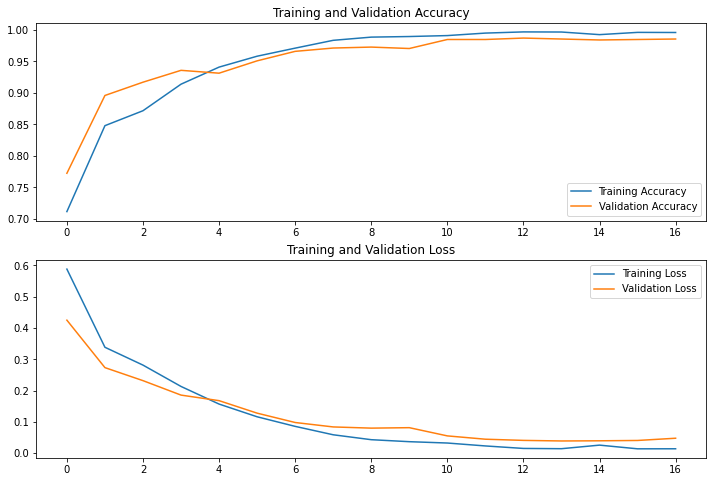

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model saving (and re-loading)

In [15]:
model.save('model.h5')

In [16]:
new_model = tf.keras.models.load_model('model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        2

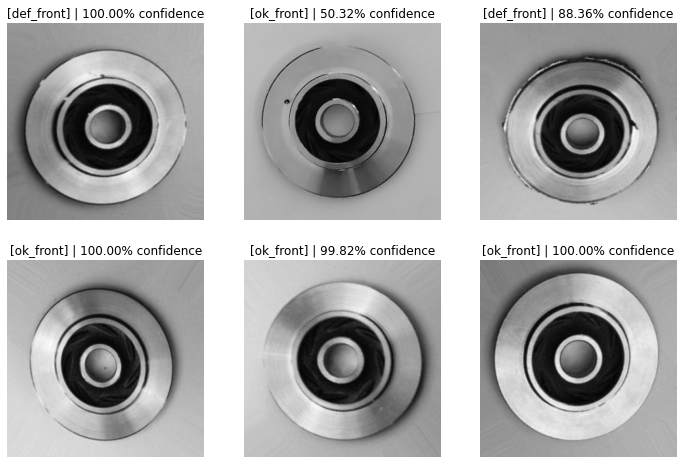

In [17]:
plt.figure(figsize=(12, 8))
counter = 1
for cls in class_names:
    path_images = path_test_data / Path(f"{cls}/*.jpeg")
    files_images = glob.glob(path_images.as_posix(),recursive = True)
    for idx in random.sample(range(0, len(files_images)), 3):
        img = cv2.imread(files_images[idx])
        img_grayscale = img[:,:,1]
        img_array = tf.keras.utils.img_to_array(img_grayscale)
        img_array = tf.expand_dims(img_array, 0)
        # predictions = model.predict(img_array) # sanity check with model in memory
        predictions = new_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        ax = plt.subplot(number_classes, 3, counter)
        pred_str = "[{}] | {:.2f}% confidence".format(class_names[np.argmax(score)], 100 * np.max(score))
        plt.title(pred_str)
        plt.axis("off")
        plt.imshow(img)

        counter += 1